# Fake News Detection - Phase 1: Data Exploration

---

**Objectifs de ce notebook**

Ce notebook constitue la première étape du pipeline de detection de fake news. Nous allons explorer les données brutes afin de comprendre leur structure, identifier les caracteristiques clés, et preparer les étapes de preprocessing.

Les étapes principales sont:
1. Configuration de l'environnement
2. Chargement des données
3. Structure des données
4. Analyses des valeurs manquantes
5. Distribution des classes
6. Analyse des longueurs des textes
7. Analyse des sujets/catégories
8. Analyse Lexicale préliminaire
9. Detection des doublons
10. Résumé et recommandations

## 1. Configuration de l'environnement

In [ ]:
# Importation des bibliotheques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Configuration de l'affichage
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')


Environnement configure avec succes.


## 2. Chargement des données

Nous travaillons avec deux fichiers CSV:
- **Fake.csv**: Articles identifiés comme fausses nouvelles
- **True.csv**: Articles identifiés comme vraies nouvelles

Cette structure est similaire au dataset WELFake utilise dans l'article de reference (Roumeliotis et al., 2025).

In [3]:
# Chargement des datasets
df_fake = pd.read_csv("data\Fake.csv", sep=",")
df_true = pd.read_csv("data\True.csv")

print(f"Fake news articles: {len(df_fake)}")
print(f"True news articles: {len(df_true)}")

Fake news articles: 23481
True news articles: 21417


In [6]:
# Ajout de la colonne Detection (0 = Fake, 1 = True)
df_fake['Detection'] = 0
df_true['Detection'] = 1

df_fake['detect_label'] = "Fake"
df_true['detect_label'] = "True"

# Fusion des deux datasets
df = pd.concat([df_fake, df_true], axis=0, ignore_index=True)

print(f"Dataset combine: {len(df):,} articles")
print("Repartition des classes:", df['Detection'].value_counts())

Dataset combine: 44,898 articles
Repartition des classes: Detection
0    23481
1    21417
Name: count, dtype: int64


## 3. Structure des données

In [18]:
print(df['title'])

0                    Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
1                              Drunk Bragging Trump Staffer Started Russian Collusion Investigation
2         Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’
3                     Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)
4                             Pope Francis Just Called Out Donald Trump During His Christmas Speech
                                                    ...                                            
44893                                 'Fully committed' NATO backs new U.S. approach on Afghanistan
44894                                          LexisNexis withdrew two products from Chinese market
44895                                             Minsk cultural hub becomes haven from authorities
44896                                 Vatican upbeat on possibility of Pope Francis visiting Russia


In [7]:
# Apercu des premieres lignes
df.head()

,title,text,subject,date,Detection,detect_label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he...",News,"December 31, 2017",0,Fake
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under th...,News,"December 31, 2017",0,Fake
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered ...",News,"December 30, 2017",0,Fake
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but ...",News,"December 29, 2017",0,Fake
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentionin...,News,"December 25, 2017",0,Fake


In [8]:
# Information sur les colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         44898 non-null  object
 1   text          44898 non-null  object
 2   subject       44898 non-null  object
 3   date          44898 non-null  object
 4   Detection     44898 non-null  int64 
 5   detect_label  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


## 4. Analyse des valeurs manquantes

La qualite des données est essentielle pour l'entrainement de modeles robustes. Nous devons identifier et quantifier les valeurs manquantes.

In [34]:
# Vérifier la ligne 1603 spécifiquement
print(f"Valeur à l'index : '{df.loc[1593, 'title']}'")
print(f"Représentation exacte: {repr(df.loc[1592, 'Detection'])}")

Valeur à l'index : ' ‘Cases Upon Cases Of Beer’: GOP Organizes Booze Party To Celebrate Stripping 24 Million Of Insurance'
Représentation exacte: 0


In [ ]:
# Calcul des valeurs manquantes par colonne
# Les valeurs manquantes sont les observations ayant pour contenus soit un text vide ou des espaces ou des tabs...
missing_data = pd.DataFrame({
    'Colonne': df.columns,
    'Valeurs_manquantes': df.apply(lambda x: x.astype(str).str.replace(r'\s+', '', regex=True).eq('').sum()),
    'Pourcentage': (df.apply(lambda x: x.astype(str).str.replace(r'\s+', '', regex=True).eq('').sum()) / len(df) * 100).round(2)
})
print("Analyse des valeurs manquantes:")
print(missing_data.to_string(index=False))

Analyse des valeurs manquantes:
     Colonne  Valeurs_manquantes  Pourcentage
       title                   0         0.00
        text                 631         1.41
     subject                   0         0.00
        date                   0         0.00
   Detection                   0         0.00
detect_label                   0         0.00


### Insight 4.1

L'analyse des valeurs manquantes nous permet de determiner la strategie de nettoyage appropriee. On note alors un faible pourcentage de valeurs manquantes (1.41 < 5%) qui peut alors être géré par suppression des lignes concernées.

## 5. Distribution des classes

L'equilibre des classes est crucial pour éviter le biais dans les modèles de classification. Un déséquilibre important peut conduire a des modeles qui favorisent la classe majoritaire.

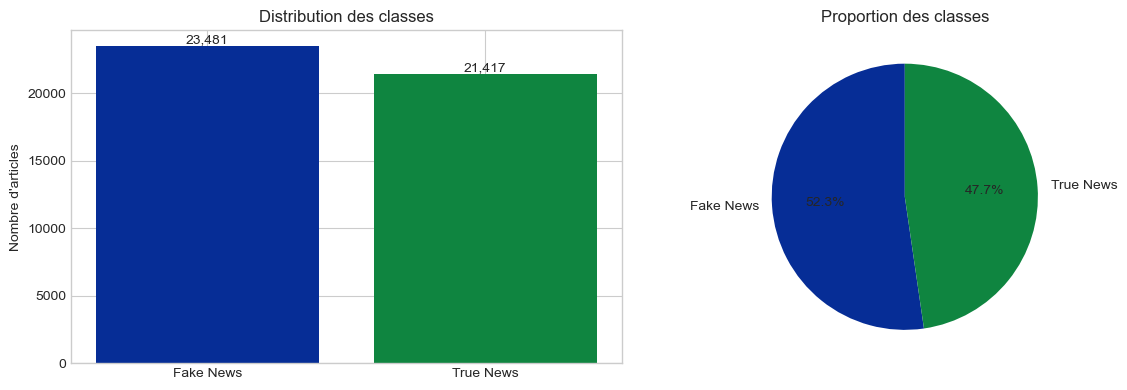

In [ ]:
# Distribution des classes
class_distribution = df['Detection'].value_counts()
class_labels = {0: 'Fake News', 1: 'True News'}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Diagramme en barres
colors = ["#062d96", "#dde4ff"]
axes[0].bar([class_labels[i] for i in class_distribution.index], 
            class_distribution.values, color=colors)
axes[0].set_title('Distribution des classes', fontsize=12)
axes[0].set_ylabel('Nombre d\'articles')
for i, v in enumerate(class_distribution.values):
    axes[0].text(i, v + 200, f'{v:,}', ha='center', fontsize=10)

# Diagramme circulaire
axes[1].pie(class_distribution.values, 
            labels=[class_labels[i] for i in class_distribution.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Proportion des classes', fontsize=12)

plt.tight_layout()
plt.show()

In [39]:
# Calcul du ratio de desequilibre
ratio = class_distribution.max() / class_distribution.min()
print(f"Ratio de desequilibre: {ratio:.2f}")

Ratio de desequilibre: 1.10


### Insight 5.1 
Comme vu dans les graphiques, il y a un certain équilibre entre les "fake" news et les "True" newsen termes de pourcentages avec respectivement des proportions de 52,3 % cotre 47,7%.
Le **ratio de déséquilibre** de 1,10 réaffirme davantage l'équilibre déjà suspectée.

## 6. Analyse de la longueur des textes

La longueur des articles est un facteur important pour le choix de l'architecture du modele. Comme mentionne dans l'article de reference, les modeles comme BERT et CNN ont une limite de 512 tokens (environ 2560 caracteres), tandis que les LLMs peuvent traiter des textes plus longs.

In [ ]:
# Calcul des longueurs
df['text_length_chars'] = df['text'].astype(str).apply(len)
df['text_length_words'] = df['text'].astype(str).apply(lambda x: len(x.split()))

print("Statistiques de longueur (en caracteres):")
print(df['text_length_chars'].describe().round(2))

Statistiques de longueur (en caracteres):
count    44898.00
mean      2469.11
std       2171.62
min          1.00
25%       1234.00
50%       2186.00
75%       3105.00
max      51794.00
Name: text_length_chars, dtype: float64


In [ ]:
print("Statistiques de longueur (en mots):")
print(df['text_length_words'].describe().round(2))


Statistiques de longueur (en mots):
count    44898.00
mean       405.28
std        351.27
min          0.00
25%        203.00
50%        362.00
75%        513.00
max       8135.00
Name: text_length_words, dtype: float64


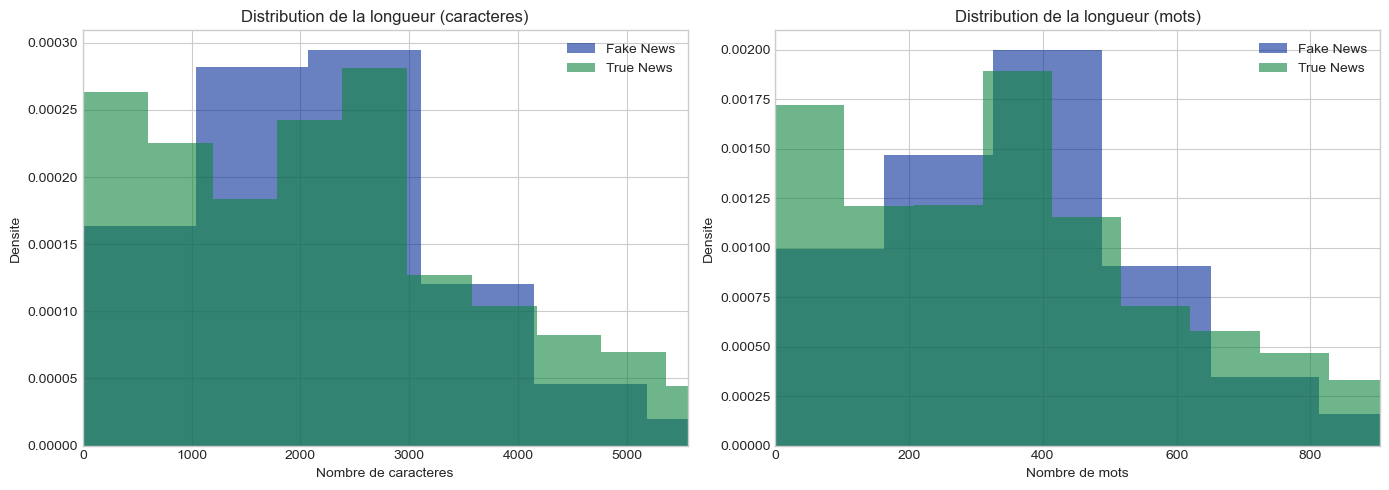

In [ ]:
# Distribution de la longueur par classe
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme de la longueur en caracteres
for label, color in zip([0, 1], ["#062d96", "#dde4ff"]):
    subset = df[df['Detection'] == label]['text_length_chars']
    axes[0].hist(subset, bins=50, alpha=0.6, color=color, 
                 label=class_labels[label], density=True)
axes[0].set_title('Distribution de la longueur (caracteres)', fontsize=12)
axes[0].set_xlabel('Nombre de caracteres')
axes[0].set_ylabel('Densite')
axes[0].legend()
axes[0].set_xlim(0, df['text_length_chars'].quantile(0.95))

# Histogramme de la longueur en mots
for label, color in zip([0, 1], ["#062d96", "#dde4ff"]):
    subset = df[df['Detection'] == label]['text_length_words']
    axes[1].hist(subset, bins=50, alpha=0.6, color=color, 
                 label=class_labels[label], density=True)
axes[1].set_title('Distribution de la longueur (mots)', fontsize=12)
axes[1].set_xlabel('Nombre de mots')
axes[1].set_ylabel('Densite')
axes[1].legend()
axes[1].set_xlim(0, df['text_length_words'].quantile(0.95))

plt.tight_layout()
plt.show()

### Insight 6.1
Les deux graphs ci-dessus, montrent les distributions à la fois des "Fake" et "True" news en termes de longueurs (d'abord en nbre de caratères puis en nbre de mots). On note que les deux distributions sont assez similaires et que la longueur seule ne permet pas de distinguer avec clarté les fake des true news.

Il nous faudra alors plonger dans le contenu des textes afin de trouver des patterns nous permettant de distinguer les news.

## 7. Analyse des sujets/categories

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


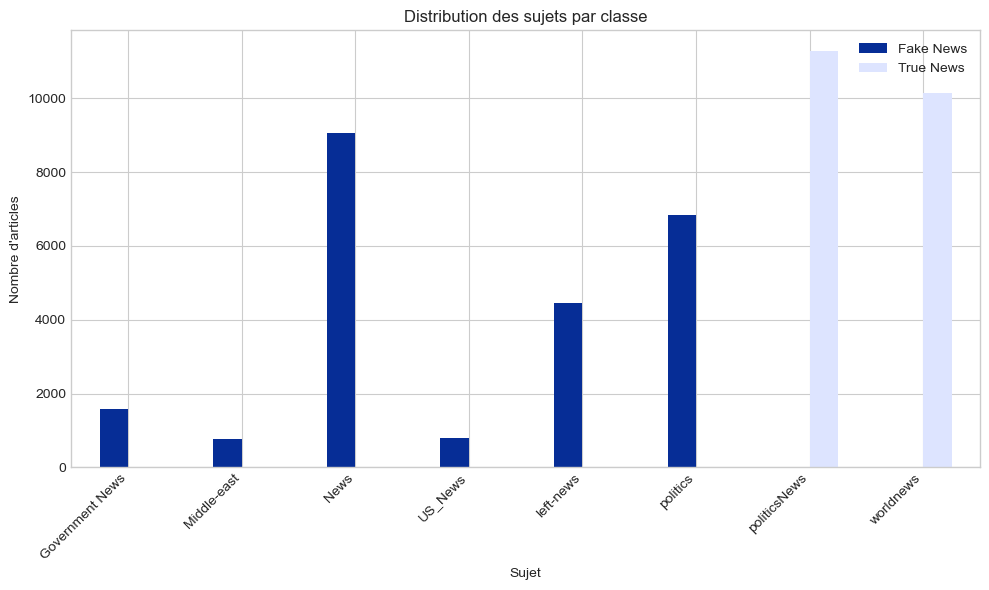

In [50]:
# Distribution des sujets   
print(df['subject'].value_counts())

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))
subject_counts = df.groupby(['subject', 'Detection']).size().unstack(fill_value=0)
subject_counts.plot(kind='bar', ax=ax, color=["#062d96", "#dde4ff"])
ax.set_title('Distribution des sujets par classe')
ax.set_xlabel('Sujet')
ax.set_ylabel('Nombre d\'articles')
ax.legend(['Fake News', 'True News'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insight 7.1
On remarque une chose très particulière. Les sujets sont parfaitement disjointes entre les fake news et les true news. Ce qui veut dire qu'à partir juste de la catégorie on peut dire avec quasi certitude si l'article est fake. En soi, on a :

    - Les "fake" catégories : Government News, Middle-east, News, US_News, left-news, politics

    - Les "true" catégories : politicsNews, worldnews

## 8. Analyse lexicale preliminaire

Une premiere exploration du vocabulaire nous permet d'identifier les mots les plus fréquents et de repérer d'éventuelles anomalies.

In [ ]:
# Fonction simple pour tokeniser
def simple_tokenize(text):
    """Tokenisation basique: mise en minuscules et split par espaces"""
    return str(text).lower().split()

# Calcul de la frequence des mots pour chaque classe
fake_words = []
true_words = []

for idx, row in df.iterrows():
    tokens = simple_tokenize(row['text'])
    if row['Detection'] == 0:
        fake_words.extend(tokens)
    else:
        true_words.extend(tokens)

fake_counter = Counter(fake_words)
true_counter = Counter(true_words)

print(f"Vocabulaire fake news: {len(fake_counter):,} mots uniques")
print(f"Vocabulaire true news: {len(true_counter):,} mots uniques")

Vocabulaire fake news: 267,271 mots uniques
Vocabulaire true news: 163,084 mots uniques


### Insight 8.1
On note que les "fake" articles en global, comportent près de 2 fois le nombre de mots uniques des "true" articles.


In [52]:
# Top 20 mots les plus frequents par classe
print("Top 20 mots - Fake News:")
for word, count in fake_counter.most_common(20):
    print(f"  {word}: {count:,}")

Top 20 mots - Fake News:
  the: 525,528
  to: 288,565
  of: 235,161
  and: 222,329
  a: 209,598
  in: 162,846
  that: 144,901
  s: 128,331
  is: 107,720
  for: 91,066
  on: 79,829
  he: 76,896
  it: 70,359
  was: 66,944
  trump: 65,511
  with: 62,025
  his: 57,885
  as: 55,422
  this: 51,753
  be: 47,794


In [53]:
print("Top 20 mots - True News:")
for word, count in true_counter.most_common(20):
    print(f"  {word}: {count:,}")

Top 20 mots - True News:
  the: 477,832
  to: 244,369
  of: 204,654
  a: 196,601
  and: 180,796
  in: 179,501
  on: 107,739
  that: 84,922
  for: 79,112
  said: 72,035
  is: 54,706
  with: 54,074
  he: 52,548
  was: 47,762
  by: 47,484
  as: 46,871
  has: 46,036
  s: 44,709
  it: 41,937
  from: 39,189


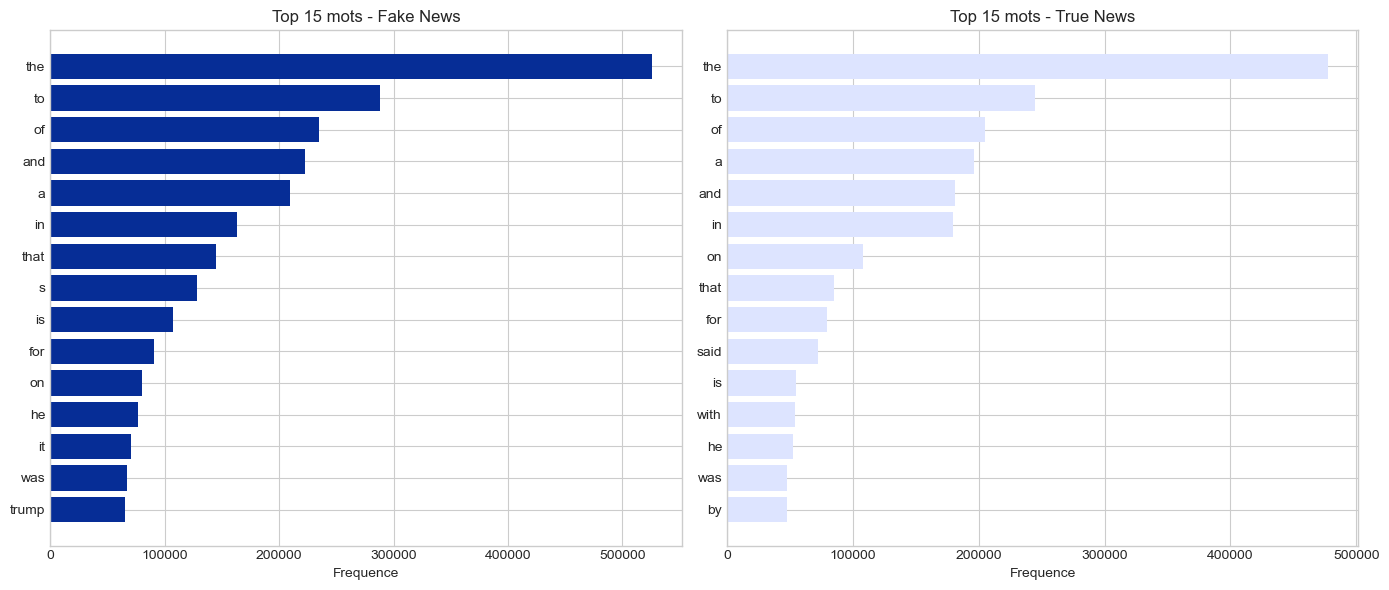

In [54]:
# Visualisation comparative des mots frequents
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fake news
top_fake = dict(fake_counter.most_common(15))
axes[0].barh(list(top_fake.keys()), list(top_fake.values()), color= "#062d96")
axes[0].set_title('Top 15 mots - Fake News', fontsize=12)
axes[0].set_xlabel('Frequence')
axes[0].invert_yaxis()

# True news
top_true = dict(true_counter.most_common(15))
axes[1].barh(list(top_true.keys()), list(top_true.values()), color="#dde4ff")
axes[1].set_title('Top 15 mots - True News', fontsize=12)
axes[1].set_xlabel('Frequence')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Insight 8.2

Les mots les plus frequents sont souvent des mots fonctionnels ("the", "a", "is", etc.) qui n'apportent pas d'information discriminante. La phase de preprocessing inclura la suppression de ces stopwords pour ameliorer la qualite des features.

Le mot qui ressort dans les fake news et non dans les true news dans le top 20 est le mot **"trump"**, ce qui peut être un indicatif dans la suite.

## 9. Detection des doublons

In [58]:
# Verification des doublons
duplicates_title = df['title'].duplicated().sum()
duplicates_text = df['text'].duplicated().sum()
duplicates_full = df.duplicated().sum()

print(f"Doublons de titre: {duplicates_title} ({duplicates_title/len(df)*100:.2f}%)")
print(f"Doublons de texte: {duplicates_text} ({duplicates_text/len(df)*100:.2f}%)")
print(f"Doublons complets: {duplicates_full} ({duplicates_full/len(df)*100:.2f}%)")

Doublons de titre: 6169 (13.74%)
Doublons de texte: 6252 (13.92%)
Doublons complets: 209 (0.47%)


### Insight 9.1
Les titres de notre base présentent des doublons mais ça ne pausent pas réellement de problèmes à condition que leurs textes respectifs soient différents en contenu. Cependant, un bon nombre des textes (6252 articles) sont des doublons. Ces derniers se verront alors traiter lors de la phase de processing.

## 10. Résumé et recommandations pour le preprocessing

### 10.1 Résumé des observations

In [62]:
print("RESUME DE L'EXPLORATION DES données")
print("--------------------------------------------------")
print(f"\n1. VOLUME DE données")
print(f"   - Total d'articles: {len(df)}")
print(f"   - Fake news: {len(df[df['Detection']==0])}")
print(f"   - True news: {len(df[df['Detection']==1])}")

print(f"\n2. QUALITE DES données")
print(f"   - Valeurs manquantes: {missing_data['Valeurs_manquantes'].sum()}")
print(f"   - Doublons: {duplicates_text}")

print(f"\n3. CARACTERISTIQUES DES TEXTES")
print(f"   - Longueur moyenne (mots): {df['text_length_words'].mean():.0f}")
print(f"   - Longueur mediane (mots): {df['text_length_words'].median():.0f}")
print(f"   - Longueur max (mots): {df['text_length_words'].max()}")

print(f"\n4. EQUILIBRE DES CLASSES")
print(f"   - Ratio: {ratio:.2f}")

RESUME DE L'EXPLORATION DES données
--------------------------------------------------

1. VOLUME DE données
   - Total d'articles: 44898
   - Fake news: 23481
   - True news: 21417

2. QUALITE DES données
   - Valeurs manquantes: 631
   - Doublons: 6252

3. CARACTERISTIQUES DES TEXTES
   - Longueur moyenne (mots): 405
   - Longueur mediane (mots): 362
   - Longueur max (mots): 8135

4. EQUILIBRE DES CLASSES
   - Ratio: 1.10


### 10.2 Recommandations pour le preprocessing

Sur la base de cette exploration, les étapes de preprocessing suivantes sont recommandées:

1. **Nettoyage des données**: Suppression des valeurs manquantes et des doublons
2. **Normalisation du texte**: Mise en minuscules, suppression de la ponctuation
3. **Tokenisation**: Decoupage du texte en tokens
4. **Suppression des stopwords**: Elimination des mots fonctionnels
5. **Lemmatisation/Stemming**: Reduction des mots a leur forme de base
6. **Limitation de la longueur**: Troncature a 2560 caracteres pour compatibilite avec BERT/CNN

In [63]:
# Sauvegarde du dataset combine pour la prochaine étape
output_path = "./data/combined_raw.csv"
df.to_csv(output_path, index=False)
print(f"\nDataset combine sauvegarde: {output_path}")


Dataset combine sauvegarde: ./data/combined_raw.csv


---

# Prochaine étape

Le notebook suivant (`fnd_02_processing.ipynb`) implementera les etapes de preprocessing identifiees dans cette exploration.

---

**References:**
- Roumeliotis, K.I., Tselikas, N.D., & Nasiopoulos, D.K. (2025). Fake News Detection and Classification: A Comparative Study of CNNs, LLMs, and NLP Models. *Future Internet*, 17, 28.